![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Legal/5.RelationExtraction_and_ZeroShot.ipynb)

# Legal Relation Extraction(RE) and Zero-shot Relation Extraction

## Colab Setup

In [1]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install johnsnowlabs 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.6/570.6 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.4/448.4 KB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880769 sha256=

In [2]:
from johnsnowlabs import nlp, finance, legal, medical

nlp.install(force_browser=True)

<IPython.core.display.Javascript object>

127.0.0.1 - - [06/Jan/2023 18:37:50] "GET /login?code=d7687qgmLZUTj8Le12KmHEjcqBlyY6 HTTP/1.1" 200 -


<IPython.core.display.Javascript object>

Licenses extracted successfully
📋 Stored John Snow Labs License in /root/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👷 Setting up  John Snow Labs home in /root/.johnsnowlabs, this might take a few minutes.
🙆 JSL Home setup in /root/.johnsnowlabs
Installing /root/.johnsnowlabs/py_installs/spark_nlp_jsl-4.2.4-py3-none-any.whl to /usr/bin/python3
Running: /usr/bin/python3 -m pip install /root/.johnsnowlabs/py_installs/spark_nlp_jsl-4.2.4-py3-none-any.whl
Installed 1 products:
💊 Spark-Healthcare==4.2.4 installed! ✅ Heal the planet with NLP! 


In [3]:
spark = nlp.start()

👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.2.4, 💊Spark-Healthcare==4.2.4, running on ⚡ PySpark==3.1.2


## Extract Relations Between Parties in an Agreement

This is a Legal Relation Extraction model, which can be used after the NER Model for extracting realtions between Parties, Document Types, Effective Dates and Aliases 

As an output, you will get the relations linking the different concepts together, if such relation exists. The list of relations is:

- **dated_as**: A document has an effective date
- **has_alias**: The alias of a party all along the document
- **has_collective_alias**: An alias hold by several parties at the same time
- **signed_by**: Between a party and the document they signed

In [4]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl", "xx")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")
        
tokenizer = nlp.Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")

embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base", "en") \
    .setInputCols("sentence", "token") \
    .setOutputCol("embeddings")\
    .setMaxSentenceLength(512)

ner_model = legal.NerModel.pretrained("legner_contract_doc_parties", "en", "legal/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter = nlp.NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

"""
ONLY NEEDED IF YOU WANT TO FILTER RELATION PAIRS OR SYNTACTIC DISTANCE
pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["document", "tokens"])\
    .setOutputCol("pos_tags")

dependency_parser = DependencyParserModel() \
    .pretrained("dependency_conllu", "en") \
    .setInputCols(["document", "pos_tags", "tokens"]) \
    .setOutputCol("dependencies")

Set a filter on pairs of named entities which will be treated as relation candidates
re_filter = RENerChunksFilter()\
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(7)\
    .setRelationPairs(['PARTY-ALIAS', 'DOC-PARTY', 'DOC-EFFDATE'])
"""
re_model = legal.RelationExtractionDLModel.pretrained("legre_contract_doc_parties", "en", "legal/models")\
    .setPredictionThreshold(0.5)\
    .setInputCols(["ner_chunk", "sentence"])\
    .setOutputCol("relations")

pipeline = nlp.Pipeline(stages=[
        document_assembler,
        sentence_detector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter,
        re_model
        ])
empty_df = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_df)

light_model = nlp.LightPipeline(model)


sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[OK!]
legner_contract_doc_parties download started this may take some time.
[OK!]
legre_contract_doc_parties download started this may take some time.
[OK!]


In [5]:
ner_model.getClasses()

['O',
 'I-DOC',
 'B-EFFDATE',
 'B-ALIAS',
 'I-ALIAS',
 'B-PARTY',
 'I-EFFDATE',
 'I-PARTY',
 'B-DOC']

### Create Generic Function to Show Relations in Dataframe

In [6]:
import pandas as pd
def get_relations_df (results, col='relations'):
    rel_pairs=[]
    for i in range(len(results)):
        for rel in results[i][col]:
            rel_pairs.append((
              rel.result, 
              rel.metadata['entity1'], 
              rel.metadata['entity1_begin'],
              rel.metadata['entity1_end'],
              rel.metadata['chunk1'], 
              rel.metadata['entity2'],
              rel.metadata['entity2_begin'],
              rel.metadata['entity2_end'],
              rel.metadata['chunk2'], 
              rel.metadata['confidence']
          ))
    rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])
    return rel_df

### Getting Result with Light Pipeline

LightPipelines are Spark NLP specific Pipelines, equivalent to Spark ML Pipeline, but meant to deal with smaller amounts of data. They’re useful working with small datasets, debugging results, or when running either training or prediction from an API that serves one-off requests.
Spark NLP LightPipelines are Spark ML pipelines converted into a single machine but the multi-threaded task, becoming more than 10x times faster for smaller amounts of data (small is relative, but 50k sentences are roughly a good maximum). To use them, we simply plug in a trained (fitted) pipeline and then annotate a plain text. We don't even need to convert the input text to DataFrame in order to feed it into a pipeline that's accepting DataFrame as an input in the first place. This feature would be quite useful when it comes to getting a prediction for a few lines of text from a trained ML model.

In [7]:
sample_text = """This INTELLECTUAL PROPERTY AGREEMENT (this "Agreement"), dated as of December 31, 2018 (the "Effective Date") is entered into by and between Armstrong Flooring, Inc., a Delaware corporation ("Seller") and AFI Licensing LLC, a Delaware limited liability company ("Licensing" and together with Seller, "Arizona") and AHF Holding, Inc. (formerly known as Tarzan HoldCo, Inc.), a Delaware corporation ("Buyer") and Armstrong Hardwood Flooring Company, a Tennessee corporation (the "Company" and together with Buyer the "Buyer Entities") (each of Arizona on the one hand and the Buyer Entities on the other hand, a "Party" and collectively, the "Parties")."""

result = light_model.fullAnnotate(sample_text)

In [8]:
rel_df = get_relations_df(result)

rel_df[rel_df["relation"] != "no_rel"]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,dated_as,DOC,5,35,INTELLECTUAL PROPERTY AGREEMENT,EFFDATE,69,85,"December 31, 2018",0.98433614
1,signed_by,DOC,5,35,INTELLECTUAL PROPERTY AGREEMENT,PARTY,141,163,"Armstrong Flooring, Inc",0.6040471
27,has_alias,PARTY,141,163,"Armstrong Flooring, Inc",ALIAS,192,197,Seller,0.96357507
50,has_alias,PARTY,205,221,AFI Licensing LLC,ALIAS,263,271,Licensing,0.95466775
81,has_alias,PARTY,315,330,"AHF Holding, Inc",ALIAS,611,615,Party,0.5387175
82,has_alias,PARTY,315,330,"AHF Holding, Inc",ALIAS,641,647,Parties,0.5387175
87,has_collective_alias,ALIAS,399,403,Buyer,ALIAS,611,615,Party,0.5539446
88,has_collective_alias,ALIAS,399,403,Buyer,ALIAS,641,647,Parties,0.5539445
89,has_alias,PARTY,411,445,Armstrong Hardwood Flooring Company,ALIAS,478,484,Company,0.9210608
92,has_alias,PARTY,411,445,Armstrong Hardwood Flooring Company,ALIAS,611,615,Party,0.5812397


In [9]:
pd.DataFrame([(x.result, x.metadata["entity"]) for x in result[0]["ner_chunk"]], columns=["text", "ner"])

,text,ner
0,INTELLECTUAL PROPERTY AGREEMENT,DOC
1,"December 31, 2018",EFFDATE
2,"Armstrong Flooring, Inc",PARTY
3,Seller,ALIAS
4,AFI Licensing LLC,PARTY
5,Licensing,ALIAS
6,Seller,ALIAS
7,"AHF Holding, Inc",PARTY
8,Buyer,ALIAS
9,Armstrong Hardwood Flooring Company,PARTY


### Visualization of Extracted Relations

We use **RelationExtractionVisualizer** method of **spark-nlp-display** library for visualization fo the extracted relations between the entities.

In [10]:
# from sparknlp_display import RelationExtractionVisualizer

re_vis = nlp.viz.RelationExtractionVisualizer()

re_vis.display(result = result[0],
           relation_col = "relations",
           document_col = "document",
           exclude_relations = ["no_rel"],
           show_relations=True
           )

## Relation Extraction Model to Infer Relations Between Elements in WHEREAS Clauses

This is a Relation Extraction model to infer relations between elements in **WHEREAS** clauses, more specifically the **SUBJECT**, the **ACTION** and the **OBJECT**. There are two relations possible: **has_subject** and **has_object**.

In [11]:
ner_model = legal.NerModel.pretrained("legner_whereas", "en", "legal/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter = nlp.NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

re_model = legal.RelationExtractionDLModel.pretrained("legre_whereas", "en", "legal/models")\
    .setPredictionThreshold(0.5)\
    .setInputCols(["ner_chunk", "sentence"])\
    .setOutputCol("relations")

pipeline = nlp.Pipeline(stages=[
        document_assembler,
        sentence_detector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter,
        re_model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

light_model = nlp.LightPipeline(model)


legner_whereas download started this may take some time.
[OK!]
legre_whereas download started this may take some time.
[OK!]


In [12]:
ner_model.getClasses()

['O',
 'B-WHEREAS_SUBJECT',
 'I-WHEREAS_OBJECT',
 'B-WHEREAS_ACTION',
 'I-WHEREAS_SUBJECT',
 'B-WHEREAS_OBJECT',
 'I-WHEREAS_ACTION']

### Getting Result with Light Pipeline

In [13]:
sample_text = """WHEREAS VerticalNet owns and operates a series of online communities ( as defined below ) that are accessible via the world wide web, each of which is designed to be an online gathering place for businesses of a certain type or within a certain industry"""

result = light_model.fullAnnotate(sample_text)

rel_df = get_relations_df(result)

rel_df[rel_df["relation"] != "no_rel"]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,has_subject,WHEREAS_SUBJECT,8,18,VerticalNet,WHEREAS_ACTION,29,36,operates,0.99839705
1,has_subject,WHEREAS_SUBJECT,8,18,VerticalNet,WHEREAS_OBJECT,38,67,a series of online communities,0.98838055
2,has_object,WHEREAS_ACTION,29,36,operates,WHEREAS_OBJECT,38,67,a series of online communities,0.8244948


In [14]:
pd.DataFrame([(x.result, x.metadata["entity"]) for x in result[0]["ner_chunk"]], columns=["text", "ner"])

,text,ner
0,VerticalNet,WHEREAS_SUBJECT
1,operates,WHEREAS_ACTION
2,a series of online communities,WHEREAS_OBJECT


### Visualization of Extracted Relations

In [15]:
# from sparknlp_display import RelationExtractionVisualizer

re_vis = nlp.viz.RelationExtractionVisualizer()

re_vis.display(result = result[0],
           relation_col = "relations",
           document_col = "document",
           exclude_relations = ["no_rel"],
           show_relations=True
           )

# Introduction to Zero-shot Relation Extraction

#### **Answering Questions on Legal Texts**
One of the latests biggest outcomes in NLP are **Language Models** and their ability to answer questions, expressed in natural language.

*This INTELLECTUAL PROPERTY AGREEMENT (this "Agreement"), dated as of December 31, 2018 (the "Effective Date") is entered into by and between Armstrong Flooring, Inc., a Delaware corporation ("Seller") and AFI Licensing LLC.*

```
    "signed_by": ["{DOC} signed by {PARTY}" ],
    "has_alias": ["{ALIAS} has alias {PARTY}","{PARTY} has alias {ALIAS}"],
````

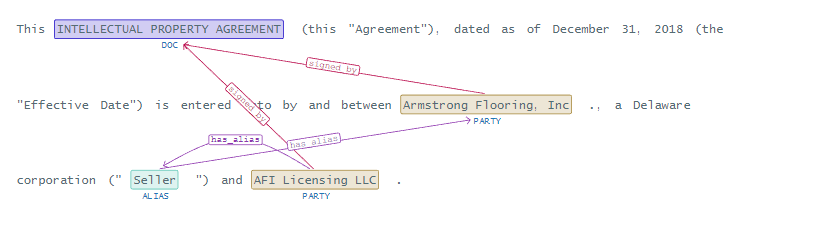



**Question Answeering (QA)** uses specific Language Models trained to carry out **Natural Language Inference (NLI)**

**NLI** works as follows:
- Given a text as a Premise (P);
- Given a hypotheses (H) as a question to be solved;
   - Then, we ask the Language Model is H is `entailed`, `contradicted` or `not related` in P. 


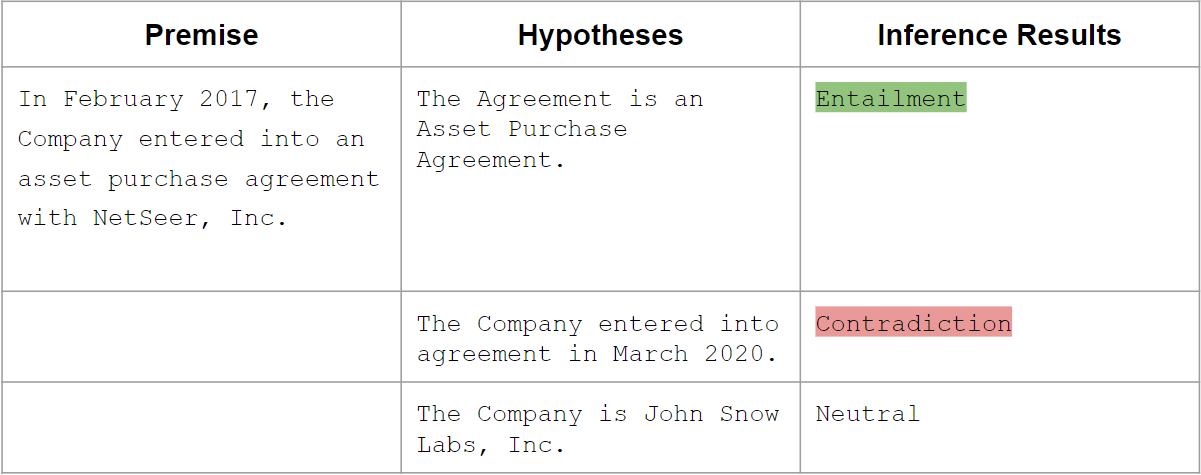

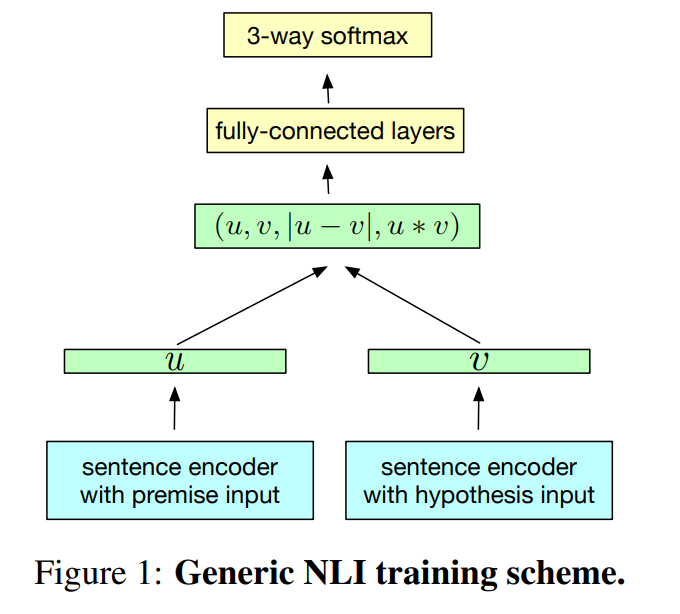

## Zero Shot Relation Extraction to Extract Relations Between Legal Entities

This is a Zero-shot Relation Extraction Model, meaning that it does not require any training data, just few examples of of the relations types you are looking for, to output a proper result.

**!!!Make sure you keep the proper syntax of the relations you want to extract!!!**

In [16]:
tokenClassifier = legal.BertForTokenClassification.pretrained("legner_obligations","en", "legal/models")\
    .setInputCols("document", "token")\
    .setOutputCol("ner")\
    .setCaseSensitive(True)

ner_converter = nlp.NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_chunk")

re_model = legal.ZeroShotRelationExtractionModel.pretrained("legre_zero_shot", "en", "legal/models")\
    .setInputCols(["ner_chunk", "document"]) \
    .setOutputCol("relations")

re_model.setRelationalCategories({
    "should_provide": ["{OBLIGATION_SUBJECT} will provide {OBLIGATION}", "{OBLIGATION_SUBJECT} should provide {OBLIGATION}"],
    "commits_with": ["{OBLIGATION_SUBJECT} to {OBLIGATION_INDIRECT_OBJECT}", "{OBLIGATION_SUBJECT} with {OBLIGATION_INDIRECT_OBJECT}"],
    "commits_to": ["{OBLIGATION_SUBJECT} commits to {OBLIGATION}"],
    "agree_to": ["{OBLIGATION_SUBJECT} agrees to {OBLIGATION}"],
})

pipeline = nlp.Pipeline(stages = [
                document_assembler,  
                tokenizer,
                tokenClassifier, 
                ner_converter,
                re_model
               ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

light_model = nlp.LightPipeline(model)

legner_obligations download started this may take some time.
[OK!]
legre_zero_shot download started this may take some time.
[OK!]


In [17]:
tokenClassifier.getClasses()

['B-OBLIGATION_ACTION',
 'I-OBLIGATION_INDIRECT_OBJECT',
 'I-OBLIGATION',
 'B-OBLIGATION_INDIRECT_OBJECT',
 'PAD',
 'I-OBLIGATION_SUBJECT',
 'I-OBLIGATION_ACTION',
 'O',
 'B-OBLIGATION_SUBJECT',
 'B-OBLIGATION']

### Getting Result with Light Pipeline

In [18]:
sample_texts = [
    """NVIDIA agrees to provide an one-year supply of hardware components""",
    """The Supplier should provide the Buyer with all the necessary components""",
    """Fox grants to Licensee exclusive right and license""",
    """The parties have agreed on the conditions of this agreement""",
    """Provider commits to provide all required technical documentation which may be necessary."""
]

result = light_model.fullAnnotate(sample_texts[0])

rel_df = get_relations_df(result)

rel_df[rel_df["relation"] != "no_rel"]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,agree_to,OBLIGATION_SUBJECT,0,5,NVIDIA,OBLIGATION,25,54,an one-year supply of hardware,0.99098474


In [19]:
sample_texts = [
    """NVIDIA agrees to provide an one-year supply of hardware components""",
    """The Supplier should provide the Buyer with all the necessary components""",
    """Fox grants to Licensee exclusive right and license""",
    """The parties have agreed on the conditions of this agreement""",
    """Provider commits to provide all required technical documentation which may be necessary."""
]

rel_df = pd.DataFrame(columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])
result = light_model.fullAnnotate(sample_texts[0])
rel_df = pd.concat([rel_df,get_relations_df(result)],axis = 0)
rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,agree_to,OBLIGATION_SUBJECT,0,5,NVIDIA,OBLIGATION,25,54,an one-year supply of hardware,0.99098474


In [20]:
sample_texts = [
    """NVIDIA agrees to provide an one-year supply of hardware components""",
    """The Supplier should provide the Buyer with all the necessary components""",
    """Fox grants to Licensee exclusive right and license""",
    """The parties have agreed on the conditions of this agreement""",
    """Provider commits to provide all required technical documentation which may be necessary."""
]

rel_df = pd.DataFrame()

for i in range(len(sample_texts)):
    result = light_model.fullAnnotate(sample_texts[i])
    rel_df = pd.concat([rel_df,get_relations_df(result)],axis = 0,ignore_index=True)

rel_df[rel_df["relation"] != "no_rel"]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,agree_to,OBLIGATION_SUBJECT,0,5,NVIDIA,OBLIGATION,25,54,an one-year supply of hardware,0.99098474
1,commits_with,OBLIGATION_SUBJECT,4,11,Supplier,OBLIGATION_INDIRECT_OBJECT,32,36,Buyer,0.948378
2,should_provide,OBLIGATION_SUBJECT,4,11,Supplier,OBLIGATION,38,70,with all the necessary components,0.99136525
3,should_provide,OBLIGATION_SUBJECT,0,2,Fox,OBLIGATION,23,37,exclusive right,0.9814685
4,commits_with,OBLIGATION_SUBJECT,0,2,Fox,OBLIGATION_INDIRECT_OBJECT,14,21,Licensee,0.970199
5,agree_to,OBLIGATION_SUBJECT,0,10,The parties,OBLIGATION,24,58,on the conditions of this agreement,0.98914194
6,should_provide,OBLIGATION_SUBJECT,0,7,Provider,OBLIGATION,28,86,all required technical documentation which may...,0.9935705


### Visualization of Extracted Relations

In [21]:
# from sparknlp_display import RelationExtractionVisualizer

re_vis = nlp.viz.RelationExtractionVisualizer()

for i in range(len(sample_texts)):
    result = light_model.fullAnnotate(sample_texts[i])
    re_vis.display(result = result[0],
               relation_col = "relations",
               document_col = "document",
               exclude_relations = ["no_rel"],
               show_relations=True
               )

In [22]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
tokenizer = nlp.Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")

embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base", "en") \
    .setInputCols("document", "token")\
    .setOutputCol("embeddings")\
    .setMaxSentenceLength(512)

tokenClassifier = legal.NerModel.pretrained('legner_contract_doc_parties', 'en', 'legal/models')\
    .setInputCols(["document", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter = nlp.NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_chunk")

re_model = legal.ZeroShotRelationExtractionModel.pretrained("legre_zero_shot", "en", "legal/models")\
    .setInputCols(["ner_chunk", "document"]) \
    .setOutputCol("relations")

re_model.setRelationalCategories({
    "signed_by": ["{DOC} signed by {PARTY}" ],
    "has_alias": ["{ALIAS} has alias {PARTY}","{PARTY} has alias {ALIAS}"],

})

pipeline = nlp.Pipeline(stages = [
                document_assembler,  
                tokenizer,
                embeddings,
                tokenClassifier, 
                ner_converter,
                re_model
               ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)



roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[OK!]
legner_contract_doc_parties download started this may take some time.
[OK!]
legre_zero_shot download started this may take some time.
[OK!]


In [23]:
light_model = nlp.LightPipeline(model)

### Getting Result with Light Pipeline

In [24]:
sample_texts = [
    """This INTELLECTUAL PROPERTY AGREEMENT (this "Agreement"), dated as of December 31, 2018 (the "Effective Date") is entered into by and between Armstrong Flooring, Inc., a Delaware corporation ("Seller") and AFI Licensing LLC."""
]

rel_df = pd.DataFrame()

for i in range(len(sample_texts)):
    result = light_model.fullAnnotate(sample_texts[i])
    rel_df = pd.concat([rel_df,get_relations_df(result)],axis = 0,ignore_index=True)

rel_df[rel_df["relation"] != "no_rel"]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,signed_by,DOC,5,35,INTELLECTUAL PROPERTY AGREEMENT,PARTY,205,221,AFI Licensing LLC,0.93487823
1,has_alias,ALIAS,192,197,Seller,PARTY,205,221,AFI Licensing LLC,0.9714116
2,has_alias,PARTY,141,163,"Armstrong Flooring, Inc",ALIAS,192,197,Seller,0.9341451
3,signed_by,DOC,5,35,INTELLECTUAL PROPERTY AGREEMENT,PARTY,141,163,"Armstrong Flooring, Inc",0.9712099


In [25]:
# from sparknlp_display import RelationExtractionVisualizer

re_vis = nlp.viz.RelationExtractionVisualizer()

for i in range(len(sample_texts)):
    result = light_model.fullAnnotate(sample_texts[i])
    re_vis.display(result = result[0],
               relation_col = "relations",
               document_col = "document",
               exclude_relations = ["no_rel"],
               show_relations=True
               )